In [1]:
import string

non_alphanums = set(chr(x) for x in range(127)) - set(string.ascii_letters) - set(string.digits)
print("Non alphanums", non_alphanums)
separators = '([' + ''.join('\\' + x for x in non_alphanums) + '])'
separators = separators.encode('ascii')
print("Separators", separators)


Non alphanums {'>', '\t', '[', '\r', '\x13', '\x1d', '<', '^', '\x04', '\x08', '\x17', '\x1b', '\\', '\x19', '`', '\x1f', '$', '\x0b', '\x14', '\x12', '\x18', ')', '=', '?', ' ', "'", '\x1c', '|', ';', '/', '\x1e', '\n', '\x07', '\x10', '\x03', '\x02', '#', '\x0c', '@', '\x16', '_', '}', '.', '-', '(', '!', '+', '\x06', ']', '{', ':', '\x01', '\x11', '\x0f', '\x05', ',', '~', '\x15', '\x00', '"', '%', '\x0e', '*', '&', '\x1a'}
Separators b'([\\>\\\t\\[\\\r\\\x13\\\x1d\\<\\^\\\x04\\\x08\\\x17\\\x1b\\\\\\\x19\\`\\\x1f\\$\\\x0b\\\x14\\\x12\\\x18\\)\\=\\?\\ \\\'\\\x1c\\|\\;\\/\\\x1e\\\n\\\x07\\\x10\\\x03\\\x02\\#\\\x0c\\@\\\x16\\_\\}\\.\\-\\(\\!\\+\\\x06\\]\\{\\:\\\x01\\\x11\\\x0f\\\x05\\,\\~\\\x15\\\x00\\"\\%\\\x0e\\*\\&\\\x1a])'


In [2]:
import re
program_line = b"""dlg = Resource.loadfromresfile(filename, win, QuoteDialog.MyQuoteDialog, 'QuoteDialog', win)"""
tokens = [t for x in re.split(separators, program_line) if (t := x.strip())]
tokens

[b'dlg',
 b'=',
 b'Resource',
 b'.',
 b'loadfromresfile',
 b'(',
 b'filename',
 b',',
 b'win',
 b',',
 b'QuoteDialog',
 b'.',
 b'MyQuoteDialog',
 b',',
 b"'",
 b'QuoteDialog',
 b"'",
 b',',
 b'win',
 b')']

In [3]:
import os
from collections import Counter

DUMP_BASE = '/home/facundo/devel/ml/dump'

# directories with 1000 files of each code type, excluding "just text" (ascii, utf8, etc)
CODE_TYPES = [
    'HTML document',
    'C source',
    'C++ source',
    'PHP script',
    'ReStructuredText file',
    'Python script',
    'Ruby script',
    'Java source',
    'Objective-C source',
    'Perl5 module source',
    'XML 1.0 document',
]

# let's collect ALL tokens present in all the program files
tokens = Counter()
for basedir in CODE_TYPES:
    print("Checking base dir:", basedir)
    for dirpath, dirnames, filenames in os.walk(os.path.join(DUMP_BASE, basedir)):
        for fname in filenames:
            fpath = os.path.join(dirpath, fname)
            with open(fpath, 'rb') as fh:
                tokens.update(t for x in re.split(separators, fh.read()) if (t := x.strip()))

Checking base dir: HTML document
Checking base dir: C source
Checking base dir: C++ source
Checking base dir: PHP script
Checking base dir: ReStructuredText file
Checking base dir: Python script
Checking base dir: Ruby script
Checking base dir: Java source
Checking base dir: Objective-C source
Checking base dir: Perl5 module source
Checking base dir: XML 1.0 document


In [4]:
different_tokens = len(tokens)
print("Total different tokens", different_tokens)
for name, quant in tokens.most_common(10):
    print("{:8d} {}".format(quant, name))

Total different tokens 213400
  870525 b'.'
  756849 b'_'
  730609 b'('
  717433 b'='
  699725 b')'
  688556 b'/'
  661461 b'"'
  640989 b','
  625121 b'-'
  594091 b'>'


In [5]:
import numpy as np

total_tokens = sum(tokens.values())
print("Total tokens found:", total_tokens)

most = total_tokens * 0.9
tot = 0
representative_data = []
for name, quant in tokens.most_common():
    representative_data.append((name, quant))
    tot += quant
    if tot > most:
        break

print("Total representative:", len(representative_data))
print("Last ten...")
for name, quant in representative_data[-10:]:
    print("{:8d} {}".format(quant, name))

Total tokens found: 20101050
Total representative: 3324
Last ten...
     289 b'enables'
     289 b'smaller'
     289 b'Creates'
     289 b'cross'
     289 b'GLFW'
     289 b'Os'
     289 b'usb'
     288 b'stylesheets'
     288 b'ad'
     288 b'WIDTH'


In [6]:
import random

# real "ML data": a list of (code_type, features) (one pair for each file)
#  code_type: the *position* of the code type corresponding to the file (needs to be an int)
#  features: a list of values, each value corresponds to how many of the tokens of that position the file has

representative_tokens = [name for name, _ in representative_data]

all_src_data = []
for idx, basedir in enumerate(CODE_TYPES):
    print("Collecting data from base dir", basedir)
    for dirpath, dirnames, filenames in os.walk(os.path.join(DUMP_BASE, basedir)):
        for fname in filenames:
            fpath = os.path.join(dirpath, fname)
            with open(fpath, 'rb') as fh:
                fcontent = fh.read()
            
            file_tokens = Counter(t for x in re.split(separators, fcontent) if (t := x.strip()))
            token_quantities = [file_tokens.get(t, 0) for t in representative_tokens]

            all_src_data.append((idx, token_quantities))

print("Src data samples:", len(all_src_data))

# shuffle, as currently is too much "per directory"
random.shuffle(all_src_data)

Src data samples: 11000


In [7]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

# representation of our model
num_classes = len(CODE_TYPES)
num_features = len(representative_tokens)

# 1st and 2nd layer number of neurons (these numbers are just chamuyo)
n_hidden_1 = 128  
n_hidden_2 = 256

# training parameters (more chamuyo)
learning_rate = 0.1

batch_size = 256


In [8]:
# separate the source data and into two pairing lists
code_types, token_quantities = zip(*all_src_data)
print("Example code types:", code_types[:5])
print("Example token quants:", token_quantities[0][:5], token_quantities[117][:5])

# convert features to float
float_quantities = np.array(token_quantities, np.float32)
print("Token quants shape:", float_quantities.shape)

# normalize EACH ONE to [0, 1]
for quants in float_quantities:
    quants /= max(quants)
print("Example normalized quants:", float_quantities[0][:5], float_quantities[117][:5])

Example code types: (2, 0, 4, 4, 5)
Example token quants: [246, 786, 246, 61, 246] [32, 32, 5, 22, 5]
Token quants shape: (11000, 3324)
Example normalized quants: [0.3129771  1.         0.3129771  0.07760815 0.3129771 ] [0.9411765  0.9411765  0.14705883 0.64705884 0.14705883]


In [9]:
# let's prepare the teching sets, input and output for training first (90% of cases) and
# then testing what's learned (the remaining 10%); 
input_training = []
output_training = []
input_testing = []
output_testing = []
for token_distribution, code_type in zip(float_quantities, code_types):
    if random.random() < .1:
        input_testing.append(token_distribution)
        output_testing.append(code_type)
    else:
        input_training.append(token_distribution)
        output_training.append(code_type)
print("Real training set: {:.2f}%".format(100 * len(input_training) / len(float_quantities)))        

Real training set: 89.70%


In [10]:
import tensorflow as tf
from tensorflow.keras import Model

class NeuralNet(Model):
    """Chamuyo al cuadrado."""
    
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.sigmoid)  # se puede cambiar a relu
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.sigmoid)  # se puede cambiar a relu
        self.out = layers.Dense(num_classes)

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

neural_net = NeuralNet()

In [11]:
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

In [12]:
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Optimización. 
def run_optimization(x, y):
    # Funciones para calcular el gradiente
    with tf.GradientTape() as g:
        # Algoritmo de forward
        pred = neural_net(x, is_training=True)
        # Computa la función de costo o pérdida utilizando entropía cruzada
        loss = cross_entropy_loss(pred, y)
        
    # Actualiza las variables de entrenamiento.
    trainable_variables = neural_net.trainable_variables

    # Computa los gradientes
    gradients = g.gradient(loss, trainable_variables)
    
    # Actualiza los nuevos parámetros W (pesos) y b (bias).
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [13]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [14]:
train_data = tf.data.Dataset.from_tensor_slices((input_training, output_training))

# NOTE: this doesn't only selectes, it completely transform the structures
#   from  <TensorSliceDataset shapes: ((3324,), ()), types: (tf.float32, tf.int32)>
#     to  <PrefetchDataset shapes: ((None, 3324), (None,)), types: (tf.float32, tf.int32)>
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

display_step = 100
training_steps = 2000

# Run training for the given number of steps.
for step, (input_batch, output_batch) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(input_batch, output_batch)
    
    if step % display_step == 0:
        pred = neural_net(input_batch, is_training=True)
        loss = cross_entropy_loss(pred, output_batch)
        acc = accuracy(pred, output_batch)
        print("Step {}: loss={:f}, accuracy={:f}".format(step, loss, acc))

Step 100: loss=2.379924, accuracy=0.125000
Step 200: loss=2.372284, accuracy=0.128906
Step 300: loss=2.366430, accuracy=0.140625
Step 400: loss=2.360768, accuracy=0.121094
Step 500: loss=2.347394, accuracy=0.109375
Step 600: loss=2.349795, accuracy=0.199219
Step 700: loss=2.312950, accuracy=0.218750
Step 800: loss=2.284508, accuracy=0.289062
Step 900: loss=2.173395, accuracy=0.335938
Step 1000: loss=2.115966, accuracy=0.300781
Step 1100: loss=1.977837, accuracy=0.441406
Step 1200: loss=1.860783, accuracy=0.425781
Step 1300: loss=1.866206, accuracy=0.425781
Step 1400: loss=1.773057, accuracy=0.402344
Step 1500: loss=1.736271, accuracy=0.546875
Step 1600: loss=1.626320, accuracy=0.578125
Step 1700: loss=1.537970, accuracy=0.539062
Step 1800: loss=1.369012, accuracy=0.609375
Step 1900: loss=1.286771, accuracy=0.625000
Step 2000: loss=1.270916, accuracy=0.640625


In [15]:
# Test model on validation set
input_testing = np.array(input_testing)
pred = neural_net(input_testing, is_training=False)
print("Test Accuracy: {:f}".format(accuracy(pred, output_testing)))

Test Accuracy: 0.578994


In [18]:
# If we consider the "more probable" prediction on each item, how well it goes?
all_guesses = neural_net(input_testing, is_training=False)
guesses_ok = [0] * len(CODE_TYPES)
guesses_bad = [0] * len(CODE_TYPES)

for guess, real in zip(all_guesses, output_testing):
    # guess is an array of len(CODE_TYPES) with a float in each position showing
    # which one is the most probable to be real, so we need to get position 
    # for the max one and check if it matches with the real real :)
    position_for_max = np.where(guess == np.amax(guess))[0][0]
    if position_for_max == real:
        guesses_ok[real] += 1
    else:
        guesses_bad[real] += 1

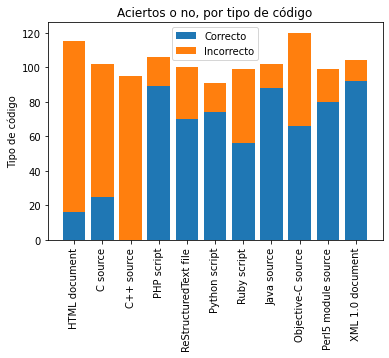

In [19]:
import numpy as np
import matplotlib.pyplot as plt

values_ok = [guesses_ok[i] for i in range(len(CODE_TYPES))]
values_bad = [guesses_bad[i] for i in range(len(CODE_TYPES))]
x_positions = np.arange(len(CODE_TYPES))

p1 = plt.bar(x_positions, guesses_ok)
p2 = plt.bar(x_positions, guesses_bad, bottom=guesses_ok)

plt.ylabel('Tipo de código')
plt.title('Aciertos o no, por tipo de código')
plt.xticks(x_positions, CODE_TYPES, rotation=90)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Correcto', 'Incorrecto'))

plt.show()